## 0. Imports


In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## 1. Load Dataset


In [15]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Initial shape:", df.shape)
df.head()


Initial shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Cleaning, Duplicate/Outlier Checks 


Duplicate rows found: 0


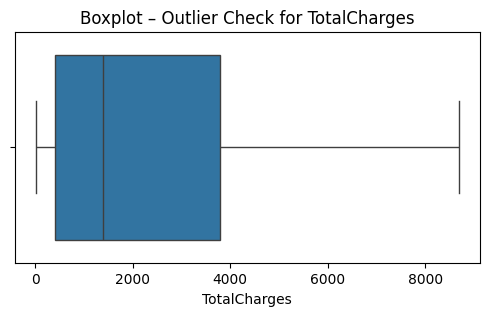

In [16]:
duplicates = df.duplicated().sum()
print("Duplicate rows found:", duplicates)
df = df.drop_duplicates()

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

plt.figure(figsize=(6,3))
sns.boxplot(x=df["TotalCharges"])
plt.title("Boxplot – Outlier Check for TotalCharges")
plt.show()

df = df.drop(columns=["customerID"])

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

## 3. Basic EDA 


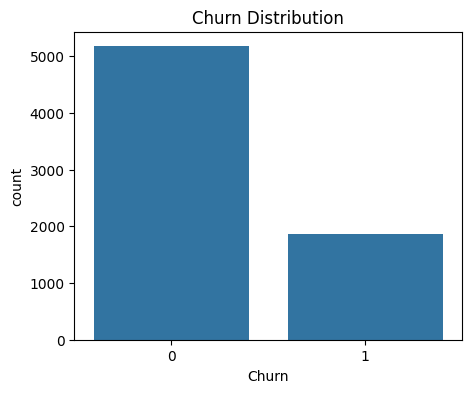

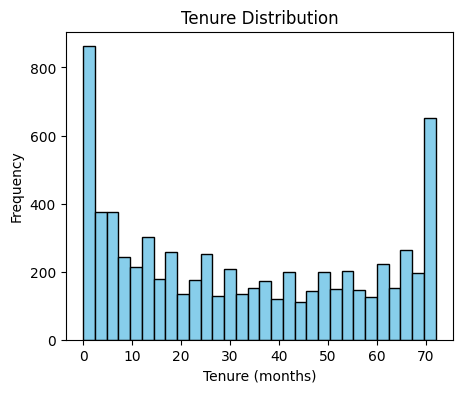

In [17]:
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.savefig("churn_distribution.png")
plt.show()

plt.figure(figsize=(5,4))
plt.hist(df["tenure"], bins=30, color='skyblue', edgecolor='black')
plt.title("Tenure Distribution")
plt.xlabel("Tenure (months)")
plt.ylabel("Frequency")
plt.savefig("tenure_histogram.png")
plt.show()


## 4. Feature/Target Split


In [18]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## 5. Train/Test Split


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5634, 19)
Test shape: (1409, 19)


## 6. Unsupervised Feature Engineering (K-Means)


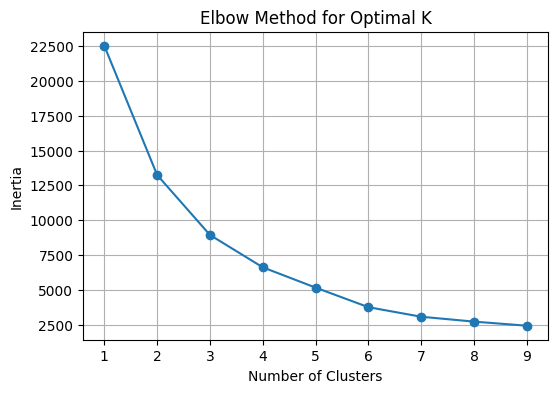

Cluster feature added. Final numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'cluster']


In [20]:
from sklearn.impute import SimpleImputer

km_imputer = SimpleImputer(strategy='median')
scaler_km = StandardScaler()

X_train_num = km_imputer.fit_transform(X_train[numeric_features])
X_train_scaled = scaler_km.fit_transform(X_train_num)

X_test_num = km_imputer.transform(X_test[numeric_features])
X_test_scaled = scaler_km.transform(X_test_num)

inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_test.fit(X_train_scaled)
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('elbow_plot.png')
plt.show()

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)

X_train = X_train.copy()
X_test = X_test.copy()

X_train["cluster"] = kmeans.fit_predict(X_train_scaled)
X_test["cluster"] = kmeans.predict(X_test_scaled)

numeric_features_with_cluster = numeric_features + ["cluster"]
print("Cluster feature added. Final numeric features:", numeric_features_with_cluster)

## 7. Preprocessor Setup


In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_with_cluster),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

## 8. Baseline Model Evaluation 


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

def evaluate_model(model, name, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f}")
    
    return {"Model": name, "Accuracy": acc, "F1-Score": f1, "Recall": recall}

pipe_lr = Pipeline([("preprocess", preprocessor), ("clf", LogisticRegression(max_iter=1000))])
results.append(evaluate_model(pipe_lr, "LogReg (Baseline)", X_train, y_train, X_test, y_test))

pipe_knn = Pipeline([("preprocess", preprocessor), ("clf", KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe_knn, "KNN", X_train, y_train, X_test, y_test))

pipe_rf = Pipeline([("preprocess", preprocessor), ("clf", RandomForestClassifier(random_state=42))])
results.append(evaluate_model(pipe_rf, "RandomForest (Baseline)", X_train, y_train, X_test, y_test))


--- LogReg (Baseline) ---
Accuracy: 0.8041 | F1: 0.6023 | Recall: 0.5588

--- KNN ---
Accuracy: 0.7637 | F1: 0.5530 | Recall: 0.5508

--- RandomForest (Baseline) ---
Accuracy: 0.7984 | F1: 0.5811 | Recall: 0.5267


## 9. Hyperparameter Tuning – Logistic Regression



--- Tuning Logistic Regression ---

--- LogReg (Tuned) ---
Accuracy: 0.8055 | F1: 0.6052 | Recall: 0.5615
Best Params: {'clf__C': 10.0}


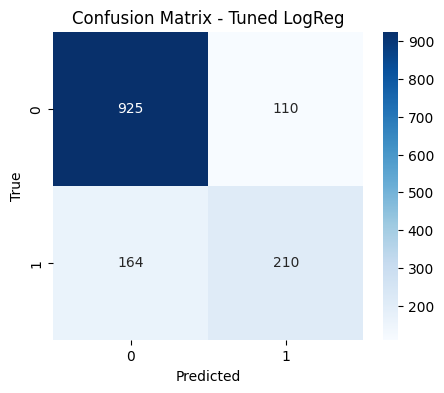

In [23]:
print("\n--- Tuning Logistic Regression ---")

param_grid_lr = {'clf__C': [0.1, 1.0, 10.0]}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)

results.append(evaluate_model(grid_lr, "LogReg (Tuned)", X_train, y_train, X_test, y_test))
best_lr = grid_lr.best_estimator_
print("Best Params:", grid_lr.best_params_)

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_lr = best_lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned LogReg")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_logreg.png")
plt.show()

## 10. Hyperparameter Tuning – Random Forest


In [24]:
print("\n--- Tuning Random Forest ---")

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, None]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)

results.append(evaluate_model(grid_rf, "RandomForest (Tuned)", X_train, y_train, X_test, y_test))

best_rf = grid_rf.best_estimator_
print("Best Params:", grid_rf.best_params_)


--- Tuning Random Forest ---

--- RandomForest (Tuned) ---
Accuracy: 0.7984 | F1: 0.5736 | Recall: 0.5107
Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 100}


## 11. Logistic Regression Coefficient Analysis


In [25]:
try:
    feature_names = best_lr.named_steps["preprocess"].get_feature_names_out()
    coefs = best_lr.named_steps["clf"].coef_[0]

    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
    coef_df.sort_values(by="Coefficient", ascending=False).head()
except Exception as e:
    print("Coefficient extraction skipped:", e)


## 12. Summary Table 


In [26]:
results_df = pd.DataFrame(results)
print("=" * 60)
print("Summary (Sorted by F1-Score for Imbalanced Class):")
results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

Summary (Sorted by F1-Score for Imbalanced Class):


,Model,Accuracy,F1-Score,Recall
0,LogReg (Tuned),0.805536,0.605187,0.561497
1,LogReg (Baseline),0.804116,0.602305,0.558824
2,RandomForest (Baseline),0.798439,0.581121,0.526738
3,RandomForest (Tuned),0.798439,0.573574,0.510695
4,KNN,0.763662,0.553020,0.550802
